# Команда: Бета Банк


**Цель:** Создать CLTV модель, которая будет выдавать вероятности перехода в каждый из 17 продуктовых кластеров в течение 12 месяцев.

Альфа-Банком предоставлены следующие **данные**:

-   Тренировочный датасет `train_data.pqt` содержит данные о 200 000 клиентах банка и их целевых переменных за три последовательных месяца (month_1, month_2, month_3)
-   Тестовый датасет `test_data.pqt` записи о 100 000 клиентах за 3 последовательных месяца (month_4, month_5, month_6)
   
-   Продуктовый кластер, в котором клиент будет находится через год - `end_cluster`. Необходимо получить вероятности перехода клиента в продуктовые кластеры для последнего месяца (month_6).

  
-    Метрикой качества выступает **ROC-AUC**.

Данные о клиентах и масскированы.

## Подключение модулей

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 11.0 MB/s eta 0:00:00


In [10]:
# работа с ОС
import os
import warnings
import time
from google.colab import drive
# работа с данными
import json
import numpy as np
import pandas as pd
from typing import Optional, Dict, Tuple
# визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from matplotlib.ticker import MaxNLocator
# работа с ML
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# модели машинного обучения
# import optuna
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
# обработка ошибок
from pyarrow import ArrowInvalid
# настройка среды выполнения
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 93)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка и изучение данных

In [8]:
def open_df(filepath: str) -> Optional[pd.DataFrame]:
    """
    Функция для чтения датасета по указанному пути

    args:
    filepath (str) - путь к файлу .pqt / .parquet

    return:
    датасет в формате pd.DataFrame, если найден файл по указанному пути
    """
    if os.path.exists(filepath):
        try:
            result: pd.DataFrame = pd.read_parquet(filepath, engine='auto')
            print(f"Файл {filepath} успешно открыт")
            return result
        except ArrowInvalid:
            print("Неверный тип файла. Поддерживаемый - .pqt или .parquet")
            return
    print(f"Файл не найден по пути {filepath}")
    return

In [13]:
# # Путь до файла train_df
# path_train_df = "/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/train_data.pqt"
# # Путь до файла test_df
# path_test_df = "/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/test_data.pqt"
# Путь до файла train_df
path_train_df = "/content/drive/MyDrive/train_data.pqt"
# Путь до файла test_df
path_test_df = "/content/drive/MyDrive/test_data.pqt"
# открытие файлов
train_df = open_df(path_train_df)
test_df = open_df(path_test_df)
# объединение файлов
df = pd.concat([train_df, test_df], ignore_index=True)

display(train_df.head(2))
display(test_df.head(2))

Файл /content/drive/MyDrive/train_data.pqt успешно открыт
Файл /content/drive/MyDrive/test_data.pqt успешно открыт


,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.7448,0.7055,1.2872,0.7481,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9512,0.5687,0.8976,0.5536,0.7744,0.9365,0.2960,0.9679,"{α, γ}",{other}
1,0,month_2,1.0496,0.8319,2.4586,1.0538,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9488,0.4997,0.7850,0.5519,0.6966,0.9902,0.2989,0.9460,"{α, γ}",{other}


,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,200000,month_4,-0.0962,0.3355,-0.1260,-0.0956,channel_code_12,city_14,city_type_0,None,...,0.0110,0.9461,0.4078,-0.1540,0.5489,0.5410,0.0317,0.2573,0.5614,{α}
1,200000,month_5,-0.0243,-0.0598,-0.1243,-0.0234,channel_code_12,city_14,city_type_0,None,...,0.0068,0.9453,0.3963,-0.1505,0.5495,0.5521,0.2378,0.2642,0.7152,{α}


### Описание признаков

In [16]:
feature_description = pd.read_excel("/content/drive/MyDrive/feature_description.xlsx")
feature_description.columns = ['col_name', 'description', 'type']
feature_description

,col_name,description,type
0,start_cluster,Стартовый кластер клиента,category
1,balance_amt_avg,Среднемесячный остаток на счетах клиента за месяц,number
2,balance_amt_max,Максимальный остаток на счетах клиента за месяц,number
3,balance_amt_min,Минимальный остаток на счетах клиента за месяц,number
4,balance_amt_day_avg,Среднедневной остаток на счетах клиента за месяц,number
5,channel_code,"Символьный код канала продаж, через который кл...",category
6,city,Населенный пункт,category
7,city_type,Тип населенного пункта,category
8,index_city_code,Код города в почтовом индексе,category
9,ogrn_days_end_month,Количество дней с момента регистрации ОГРН до ...,number


### Базовый анализ данных

In [11]:
print(f"Количество записей в тренировочных данных: {len(train_df)}")
print(f"Количество записей в тестовых данных: {len(test_df)}")

Количество записей в тренировочных данных: 600000
Количество записей в тестовых данных: 290120


Реальное количество записей в тестовых данных не делится на 3, следовательно есть дисбаланс по месяцам.

In [14]:
df.dtypes.value_counts()

float64    81
object     11
int64       1
Name: count, dtype: int64

Признаки по большей части представляют собой числа с плавающей точкой, также присутствует 11 категориальных признаков, их необходимо закодировать.

In [15]:
df.duplicated(keep='first').sum()

0

Дубликаты записей отсутствуют.

In [17]:
df['start_cluster'].value_counts()

start_cluster
{α}          491192
{}           107072
{α, η}        57458
{α, γ}        43129
{other}       42545
{α, β}        13498
{α, δ}        11350
{α, ε}         7464
{α, θ}         6348
{α, ψ}         3876
{α, μ}         1883
{α, ε, η}      1620
{α, ε, θ}      1083
{α, λ}          997
{α, ε, ψ}       462
{λ}             114
{α, π}           29
Name: count, dtype: int64

Распределение основного признака (начального кластера, из которого будет осуществляться переход в конечный кластер, являющийся целевой переменной) сильно дизбалансное.

### Пропущенные значения в признаках

In [ ]:
def plt_null_df(df: pd.DataFrame) -> None:
    """
    Функция построение графика пропущенных значений в признаках

    args:
    df (pd.DataFrame) - датафрейм с рассматриваемыми признаками

    return:
    Функция строит график без возврата результата
    """
    plt.figure(figsize=(30, 18))
    plt.imshow(df, aspect="auto", interpolation="nearest", cmap="viridis")
    # указание признаков в качестве отметок на оси абсцисс
    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
    # имена осей
    plt.xlabel("Признак")
    plt.ylabel("Количество пропущенных значений (жёлтый)")
    # визуализация графика
    plt.show()

In [21]:
df.isna().sum()

id                              0
date                            0
balance_amt_avg             95060
balance_amt_max             95060
balance_amt_min             95060
balance_amt_day_avg         95060
channel_code                62878
city                       138956
city_type                  139336
index_city_code            481685
ogrn_days_end_month         45751
ogrn_days_end_quarter       45751
ogrn_month                  45751
ogrn_year                   45751
ft_registration_date        46198
max_founderpres            496784
min_founderpres            496784
ogrn_exist_months           45751
okved                       46372
segment                     44171
sum_of_paym_2m             222345
sum_of_paym_6m             222345
sum_of_paym_1y             222345
sum_a_oper_1m                   0
cnt_a_oper_1m              291391
sum_b_oper_1m                   0
cnt_b_oper_1m              291391
sum_c_oper_1m                   0
cnt_c_oper_1m              291391
sum_deb_d_oper

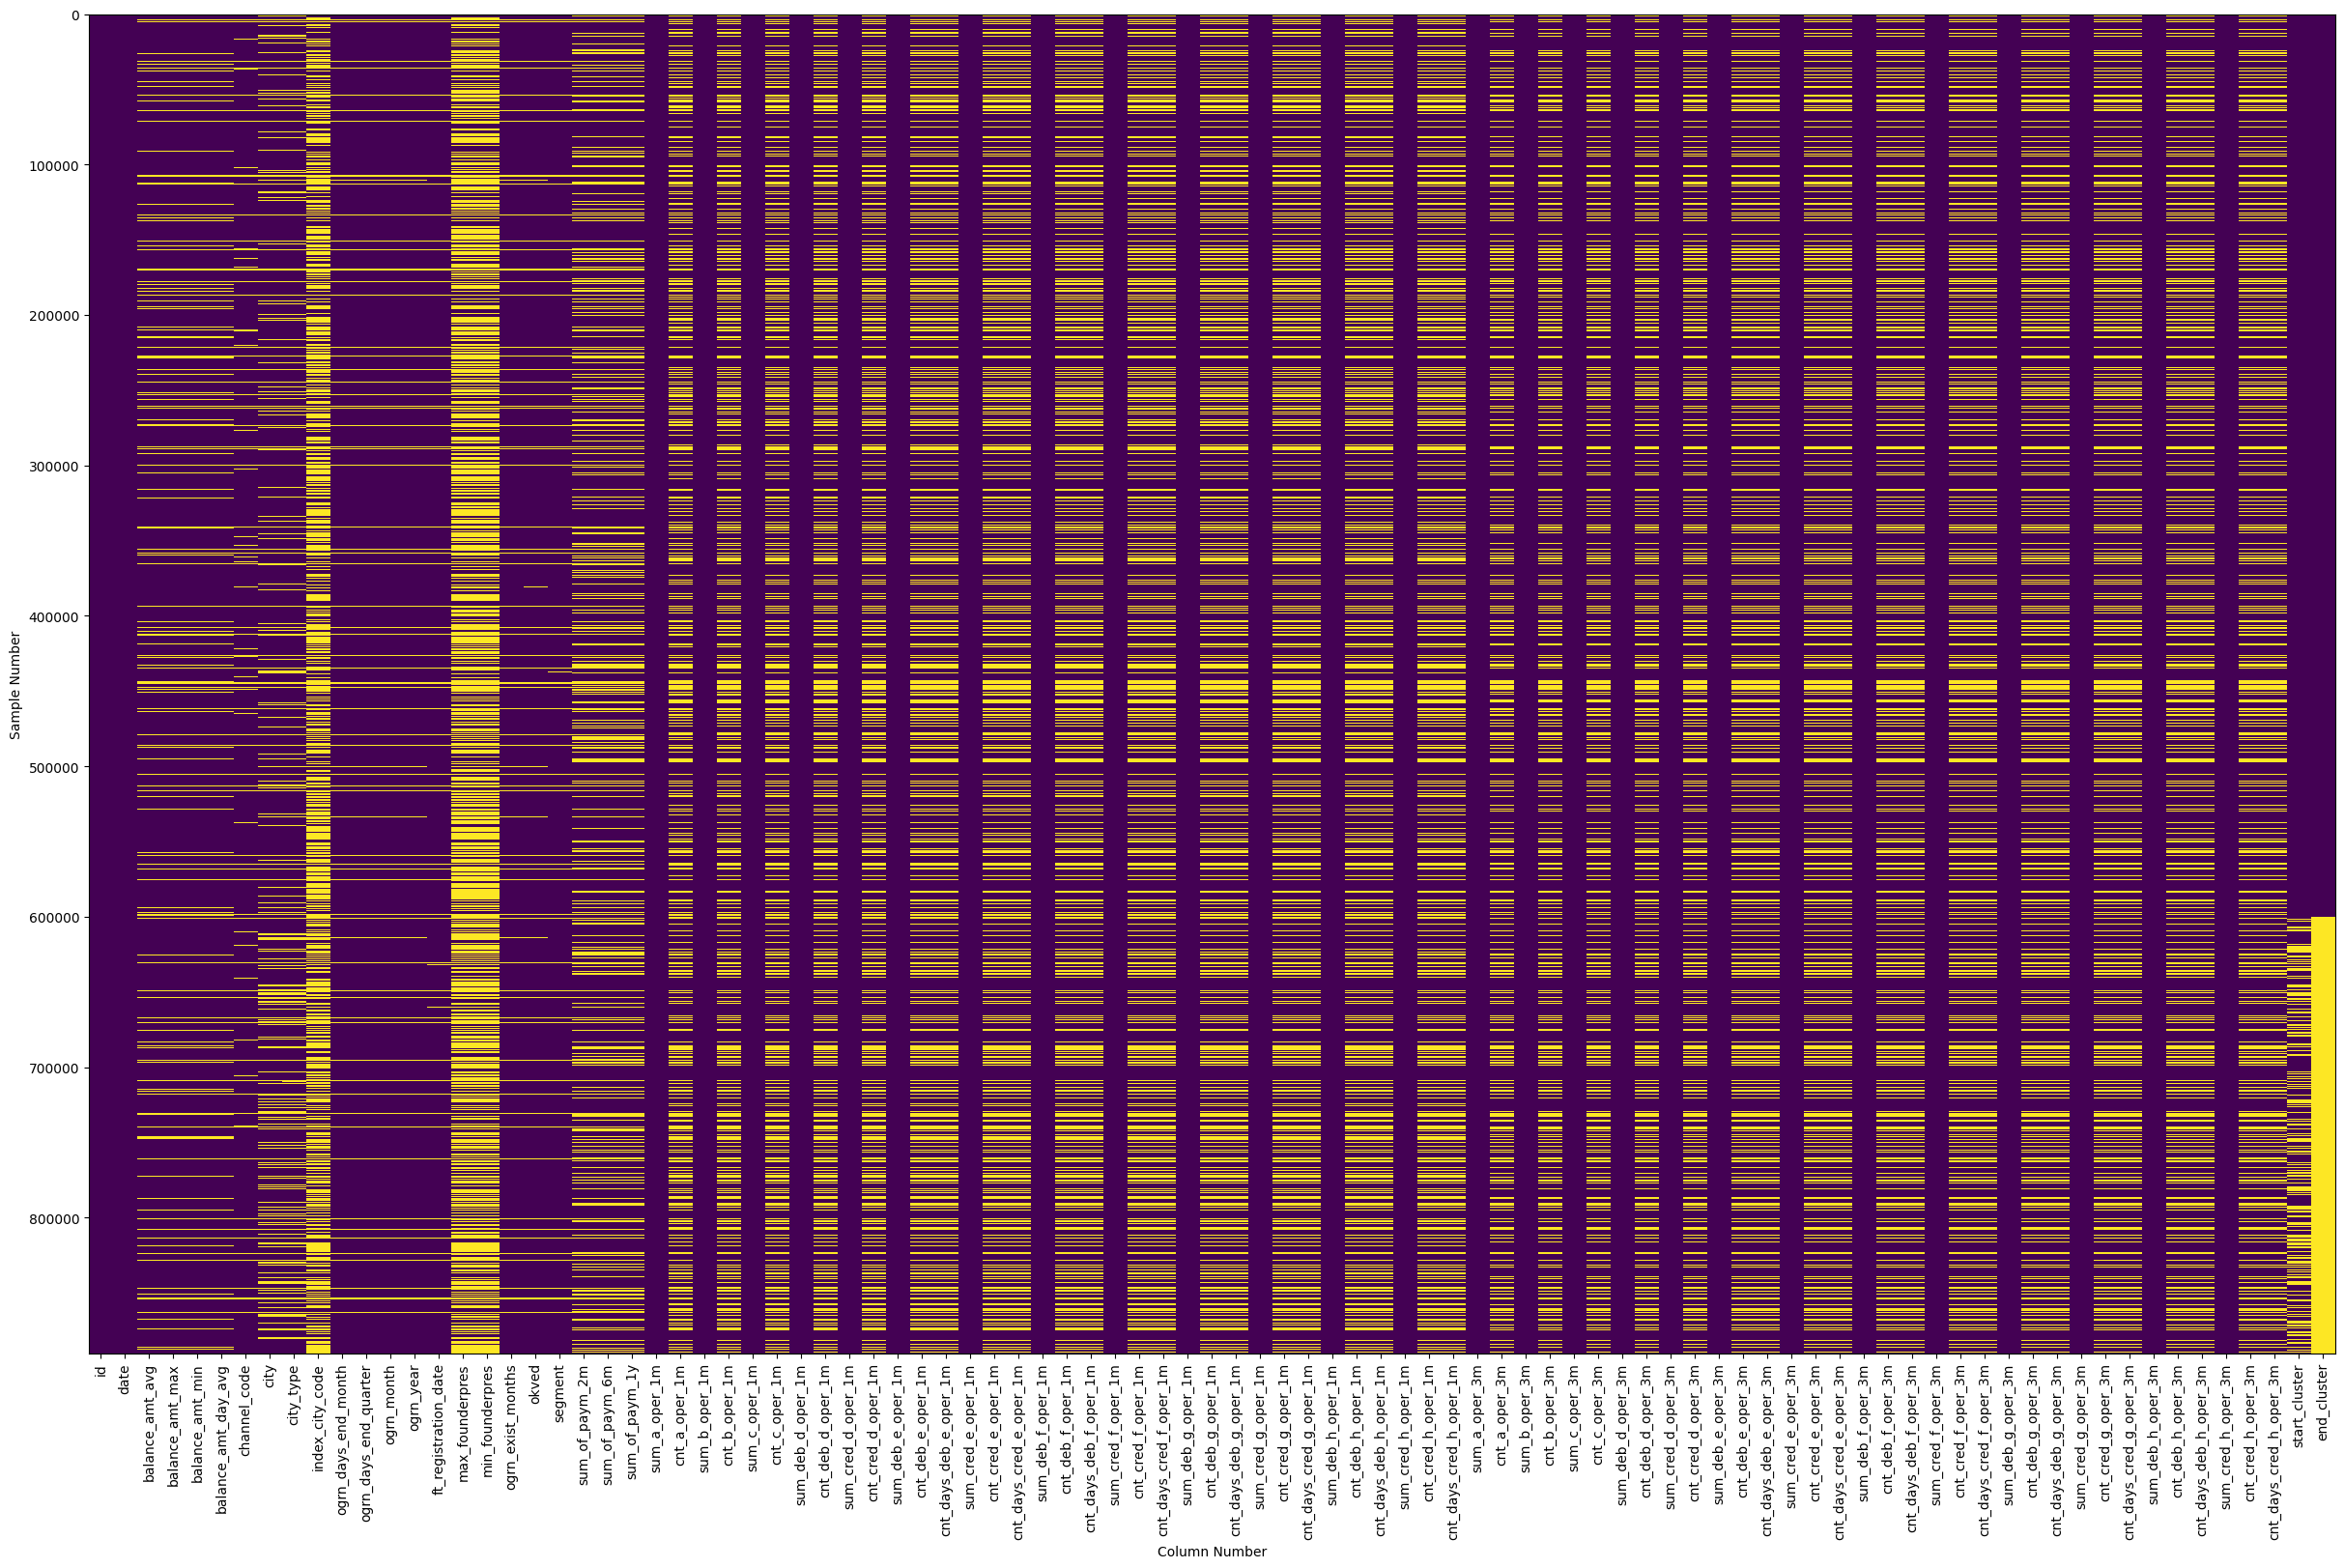

In [ ]:
plt_null_df(df.isna())

Большое количество пропущенных данных, которые необходимо восстановить для увеличения точности модели.
- Заметно, что последний месяц (month_6) признака start_cluster, для которого отсутствует end_cluster имеет почти половину пропущенных значений. Их необходимо восстановить алгоритмически или с помощью модели ML.

### Уникальных значения признаков

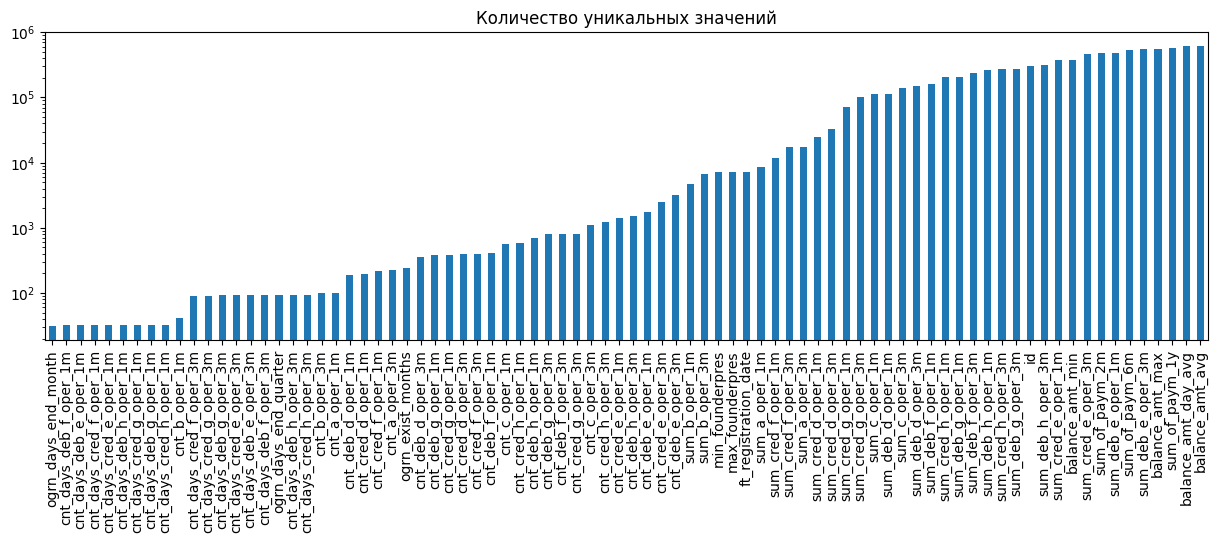

In [18]:
unique_values = df.select_dtypes(include="number").nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Количество уникальных значений");

### Корреляция признаков

In [19]:
def visualize_corr(data: pd.DataFrame) -> None:
    """
    Функция построение тепловой карты корреляции признаков

    args:
    data (pd.DataFrame) - датафрейм с рассматриваемыми признаками=

    return:
    Функция строит график без возврата результата
    """
    num_type_corr_train = data.select_dtypes(include='number').corr()
    # получение значений ниже главной диагонали матрицы
    mask = np.triu(num_type_corr_train, 1)
    plt.figure(figsize=(20, 15))
    dataplot = sns.heatmap(num_type_corr_train, mask=mask,
                           cmap="YlGnBu", annot=True, fmt=".1f",
                           annot_kws={'size': 5})
    # установление максимального количества отображаемых признаков
    dataplot.xaxis.set_major_locator(MaxNLocator(len(num_type_corr_train.columns)))
    dataplot.yaxis.set_major_locator(MaxNLocator(len(num_type_corr_train.columns)))
    # указание значений по абсциссе и ординате
    dataplot.set_xticklabels(num_type_corr_train.columns, rotation=90, fontsize=7)
    dataplot.set_yticklabels(num_type_corr_train.columns, rotation=0, fontsize=7)
    # отображение графика
    plt.show()

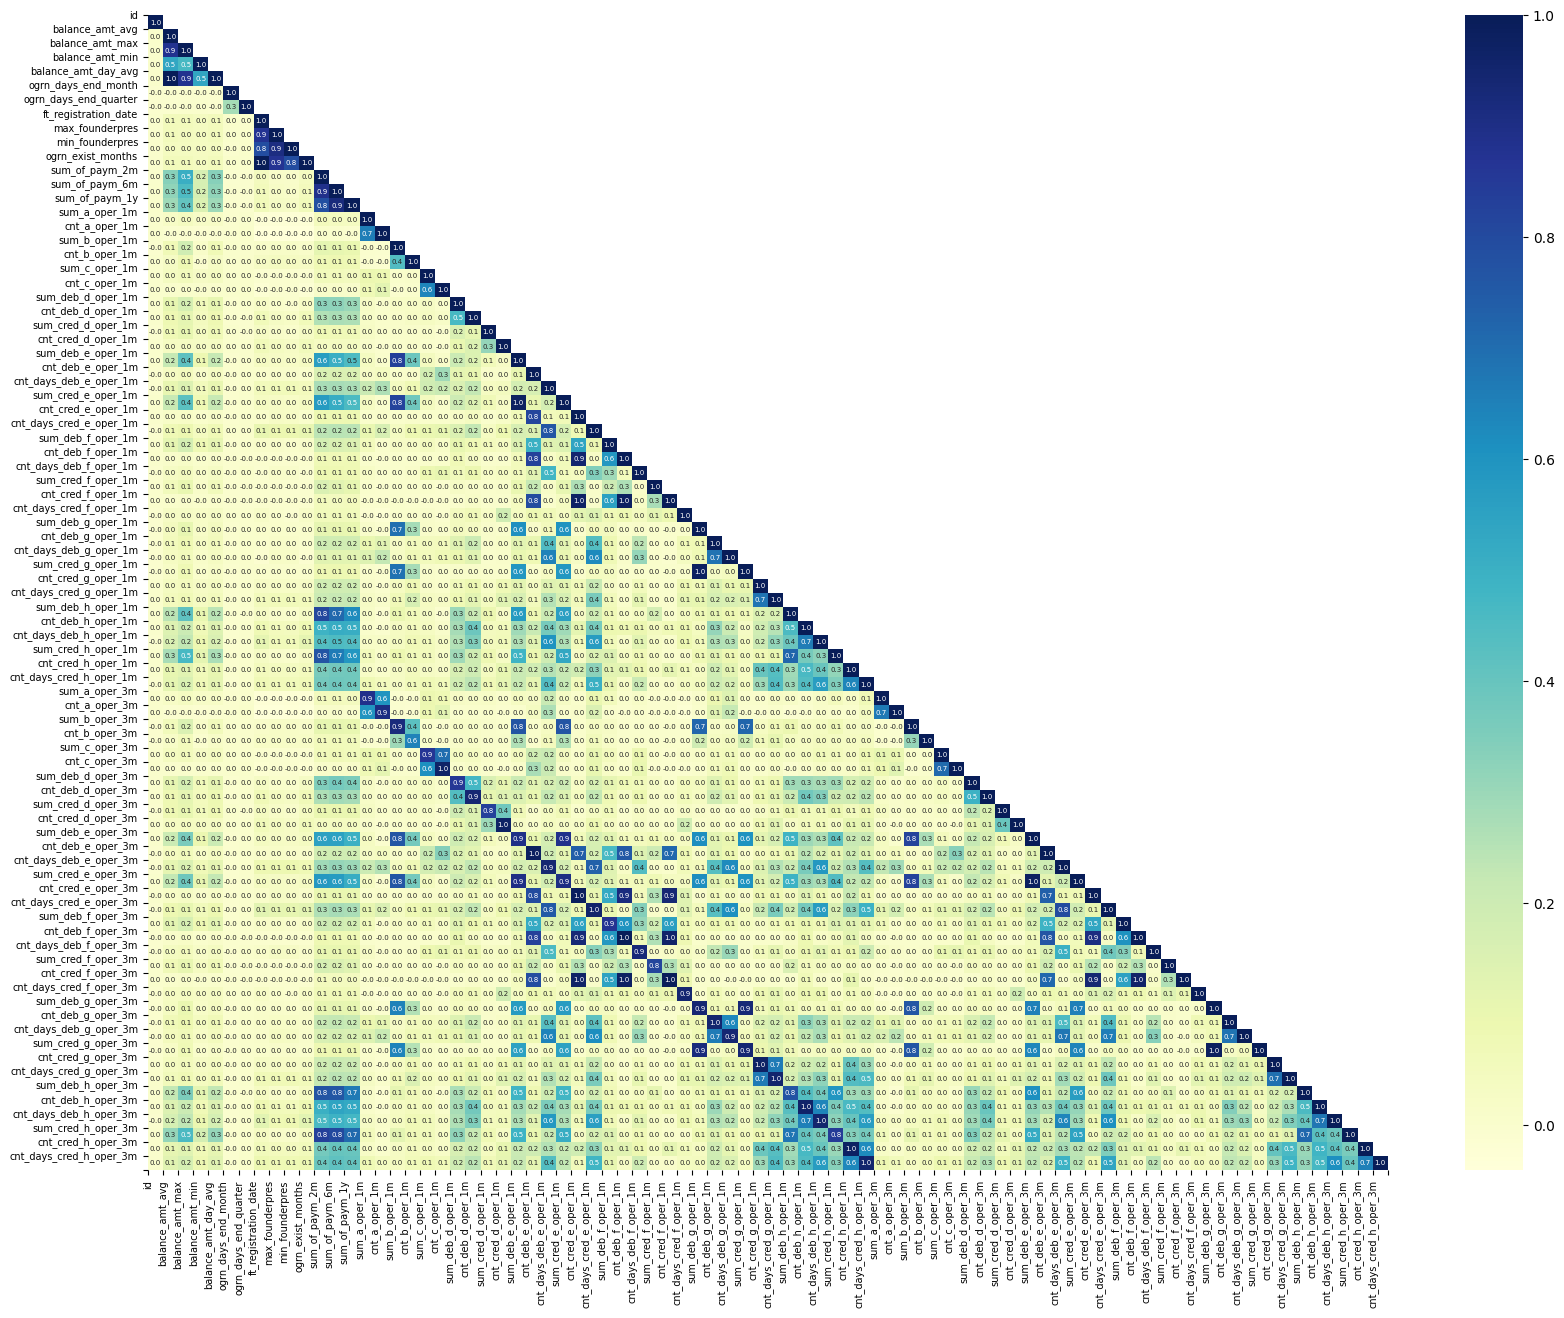

In [20]:
visualize_corr(train_df)

Некоторые признаки коррелируют между собой с уровнем корреляции > 90%.

## Feature engineering

Тут кратко описание секции

###  AVG

Очень много плохих столбцов sum но  cnt хорошие и можно сгенирировать avg

In [ ]:
numeric_cols = df.select_dtypes(include=['number']).columns
for col in numeric_cols:
    min_val = df[col].min()
    df[col].fillna(min_val, inplace=True)


In [ ]:
df['avg_a_oper_1m'] = df['sum_a_oper_1m'] / df['cnt_a_oper_1m']
df['avg_b_oper_1m'] = df['sum_b_oper_1m'] / df['cnt_b_oper_1m']
df['avg_c_oper_1m'] = df['sum_c_oper_1m'] / df['cnt_c_oper_1m']

df['avg_deb_d_oper_1m'] = df['sum_deb_d_oper_1m'] / df['cnt_deb_d_oper_1m']
df['avg_cred_d_oper_1m'] = df['sum_cred_d_oper_1m'] / df['cnt_cred_d_oper_1m']

df['avg_deb_e_oper_1m'] = df['sum_deb_e_oper_1m'] / df['cnt_deb_e_oper_1m']
df['avg_cred_e_oper_1m'] = df['sum_cred_e_oper_1m'] / df['cnt_cred_e_oper_1m']


df['avg_deb_f_oper_1m'] = df['sum_deb_f_oper_1m'] / df['cnt_deb_f_oper_1m']
df['avg_cred_f_oper_1m'] = df['sum_cred_f_oper_1m'] / df['cnt_cred_f_oper_1m']

df['avg_deb_g_oper_1m'] = df['sum_deb_g_oper_1m'] / df['cnt_deb_g_oper_1m']
df['avg_cred_g_oper_1m'] = df['sum_cred_g_oper_1m'] / df['cnt_cred_g_oper_1m']

df['avg_deb_h_oper_1m'] = df['sum_deb_h_oper_1m'] / df['cnt_deb_h_oper_1m']
df['avg_cred_h_oper_1m'] = df['sum_cred_h_oper_1m'] / df['cnt_cred_h_oper_1m']


df['avg_a_oper_3m'] = df['sum_a_oper_3m'] / df['cnt_a_oper_3m']
df['avg_b_oper_3m'] = df['sum_b_oper_3m'] / df['cnt_b_oper_3m']
df['avg_c_oper_3m'] = df['sum_c_oper_3m'] / df['cnt_c_oper_3m']

df['avg_deb_d_oper_3m'] = df['sum_deb_d_oper_3m'] / df['cnt_deb_d_oper_3m']
df['avg_cred_d_oper_3m'] = df['sum_cred_d_oper_3m'] / df['cnt_cred_d_oper_3m']

df['avg_deb_e_oper_3m'] = df['sum_deb_e_oper_3m'] / df['cnt_deb_e_oper_3m']
df['avg_cred_e_oper_3m'] = df['sum_cred_e_oper_3m'] / df['cnt_cred_e_oper_3m']

df['avg_deb_f_oper_3m'] = df['sum_deb_f_oper_3m'] / df['cnt_deb_f_oper_3m']
df['avg_cred_f_oper_3m'] = df['sum_cred_f_oper_3m'] / df['cnt_cred_f_oper_3m']

df['avg_deb_g_oper_3m'] = df['sum_deb_g_oper_3m'] / df['cnt_deb_g_oper_3m']
df['avg_cred_g_oper_3m'] = df['sum_cred_g_oper_3m'] / df['cnt_cred_g_oper_3m']

df['avg_deb_h_oper_3m'] = df['sum_deb_h_oper_3m'] / df['cnt_deb_h_oper_3m']
df['avg_cred_h_oper_3m'] = df['sum_cred_h_oper_3m'] / df['cnt_cred_h_oper_3m']

### Восстановление категориальных данных

In [ ]:
def restore_cal(x):
    if x.isna().any() and not x.isna().all():
      return x.fillna(x.dropna().iloc[-1])
    return x

In [ ]:
cat_columns_to_restore = ['channel_code', 'city',
                          'city_type', 'ogrn_month', 'ogrn_year', 'okved', 'segment']

for column in cat_columns_to_restore:
  df[column] = df.groupby('id')[column].apply(
      lambda x: restore_cal(x)).reset_index()[column]
  print(f"Колонка - {column} - восстановлена")

Колонка - channel_code - восстановлена
Колонка - city - восстановлена
Колонка - city_type - восстановлена
Колонка - ogrn_month - восстановлена
Колонка - ogrn_year - восстановлена
Колонка - okved - восстановлена
Колонка - segment - восстановлена


In [ ]:
df

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,avg_deb_d_oper_3m,avg_cred_d_oper_3m,avg_deb_e_oper_3m,avg_cred_e_oper_3m,avg_deb_f_oper_3m,avg_cred_f_oper_3m,avg_deb_g_oper_3m,avg_cred_g_oper_3m,avg_deb_h_oper_3m,avg_cred_h_oper_3m
0,0,month_1,0.7448,0.7055,1.2872,0.7481,channel_code_5,city_23,city_type_0,index_city_code_39,...,-0.1646,-0.2751,0.8369,0.5045,-0.5317,-0.1032,-0.0887,0.1964,1.6213,3.1640
1,0,month_2,1.0496,0.8319,2.4586,1.0538,channel_code_5,city_23,city_type_0,index_city_code_39,...,-0.1467,-0.2751,0.7095,0.4758,-0.4970,-0.1032,-0.0887,0.1318,1.4224,3.3130
2,0,month_3,0.6927,0.7403,0.4300,0.6957,channel_code_5,city_23,city_type_0,index_city_code_39,...,-0.1467,-0.2751,0.8142,0.3247,-0.4970,-0.1032,-0.0887,0.0355,1.5916,2.7476
3,1,month_1,-0.0816,-0.0919,-0.1140,-0.0809,channel_code_2,city_14,city_type_0,None,...,0.1973,-0.2751,0.4489,0.2257,-0.6970,-0.1032,0.1113,-0.0260,0.6512,-0.7258
4,1,month_2,-0.0950,-0.1005,-0.1193,-0.0943,channel_code_2,city_14,city_type_0,None,...,0.3113,-0.2751,0.1607,0.0689,-0.6813,-0.1032,0.1605,-0.0253,0.1201,-0.7195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890115,299998,month_5,-0.1568,-0.2050,-0.1260,-0.1563,channel_code_9,city_25,city_type_0,None,...,-0.1646,-0.2751,-0.3593,-0.1812,-0.7464,-0.1032,-0.0887,-0.0303,-0.3028,-0.8015
890116,299998,month_6,-0.1553,-0.2037,-0.1260,-0.1560,channel_code_9,city_25,city_type_0,index_city_code_30,...,-0.1646,-0.2751,-0.3593,-0.1810,-0.7464,-0.1032,-0.0887,-0.0303,-0.3028,-0.8015
890117,299999,month_4,-0.1459,-0.1733,-0.1260,-0.1454,channel_code_9,city_6,city_type_0,index_city_code_34,...,-0.1646,-0.2751,-0.2815,-0.1387,-0.7464,-0.1032,-0.0887,-0.0303,-0.1772,-0.4012
890118,299999,month_5,-0.1364,-0.1639,-0.1215,-0.1359,channel_code_9,city_6,city_type_0,index_city_code_34,...,-0.1646,-0.2751,-0.2164,-0.1104,-0.7464,-0.1032,-0.0735,-0.0303,-0.0863,-0.1375


In [ ]:
df.to_parquet("df_after_cat_restore_fill_min.pqt")

In [ ]:
df = pd.read_parquet("df_after_cat_restore_fill_min.pqt")

# df = pd.read_parquet("/kaggle/input/alfa-hackaton/df.pqt")

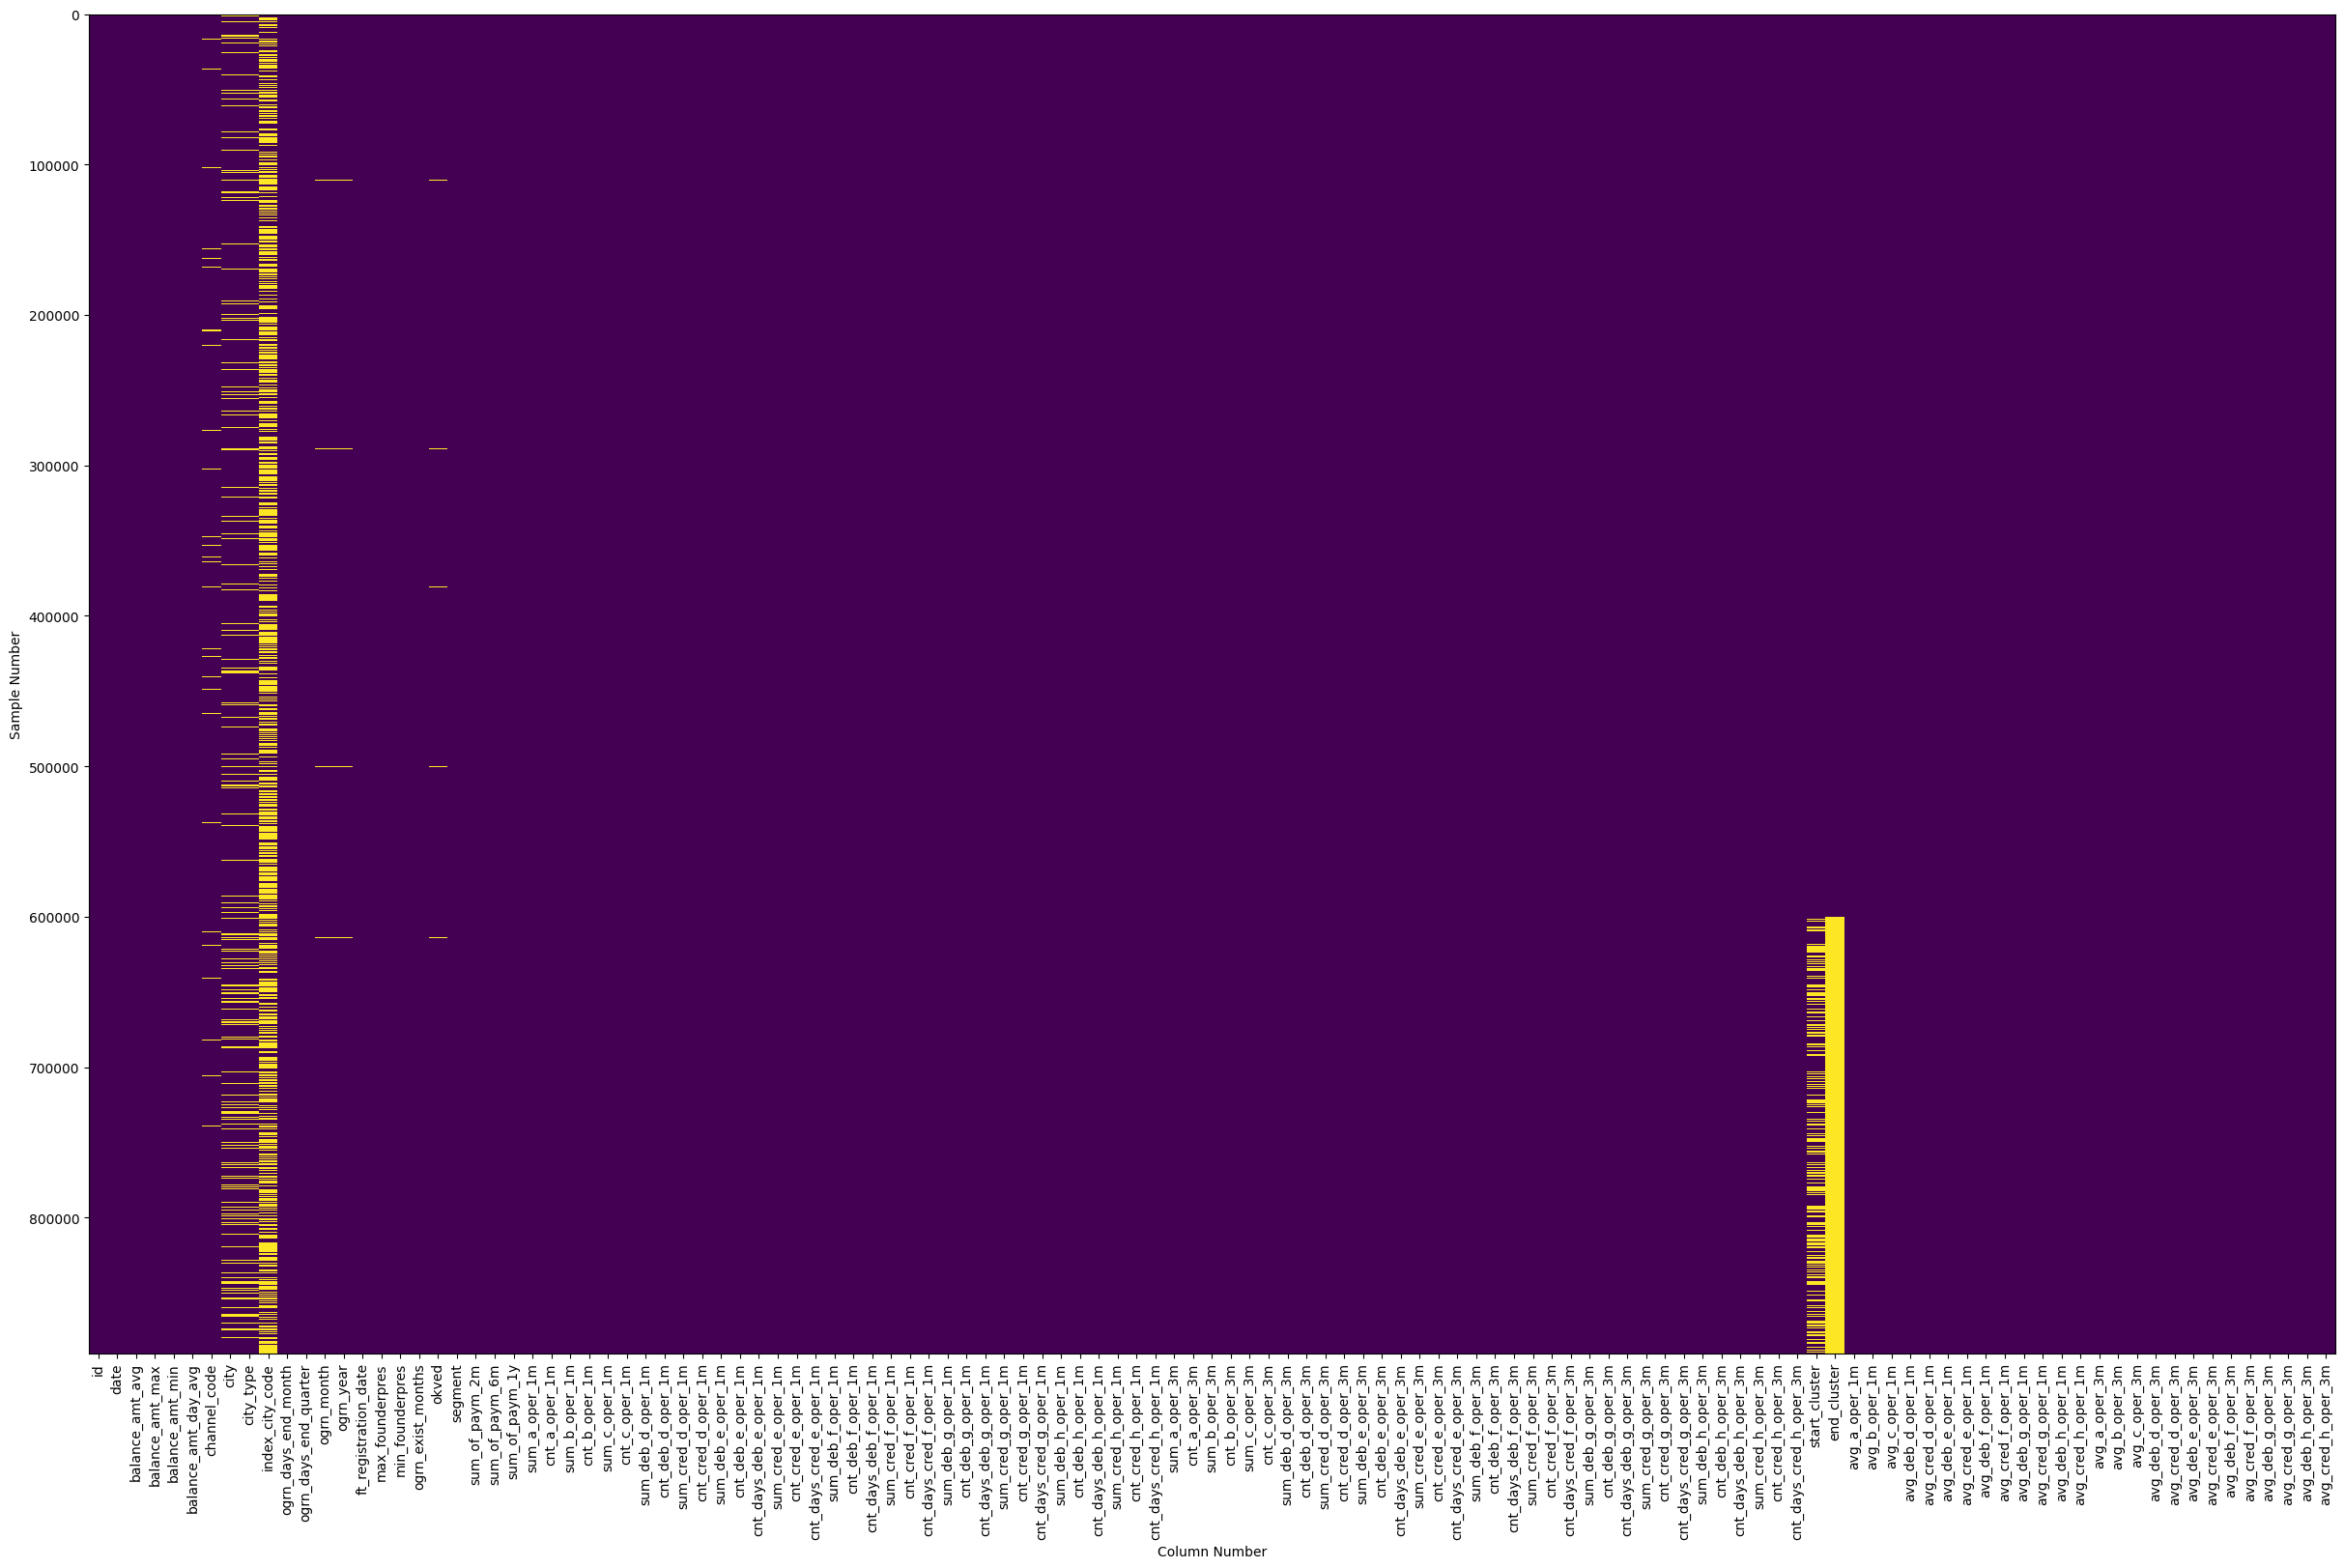

In [ ]:
plt_null_df(df.isna())

In [ ]:
# columns_to_drop = [
#     'balance_amt_max',
#     'balance_amt_min',
#     'balance_amt_day_avg',
#     'index_city_code',
#     'max_founderpres',
#     'min_founderpres',
#     'ogrn_exist_months',
#     'sum_a_oper_1m',
#     'sum_b_oper_1m',
#     'sum_c_oper_1m',
#     'sum_deb_d_oper_1m',
#     'sum_cred_d_oper_1m',
#     'sum_deb_e_oper_1m',
#     'sum_cred_e_oper_1m',
#     'sum_deb_f_oper_1m',
#     'sum_cred_f_oper_1m',
#     'sum_deb_g_oper_1m',
#     'sum_cred_g_oper_1m',
#     'sum_deb_h_oper_1m',
#     'sum_cred_h_oper_1m',
#     'sum_a_oper_3m',
#     'sum_b_oper_3m',
#     'sum_c_oper_3m',
#     'sum_deb_d_oper_3m',
#     'sum_cred_d_oper_3m',
#     'sum_deb_e_oper_3m',
#     'sum_cred_e_oper_3m',
#     'sum_deb_f_oper_3m',
#     'sum_cred_f_oper_3m',
#     'sum_deb_g_oper_3m',
#     'sum_cred_g_oper_3m',
#     'sum_deb_h_oper_3m',
#     'sum_cred_h_oper_3m']


# df = df.drop(columns=columns_to_drop)


columns_to_drop = [

    'index_city_code',
    'max_founderpres',
    'min_founderpres',
    'ogrn_exist_months',
]


df = df.drop(columns=columns_to_drop)

In [ ]:
cat_cols = [
          "channel_code", "city", "city_type",
          "okved", "segment", "start_cluster", "ogrn_month", "ogrn_year",
      ]



df['date'] = df['date'].replace({'month_4': 'month_1', 'month_5': 'month_2', 'month_6': 'month_3'})

df[cat_cols] = df[cat_cols].astype("object")

### Создание таблицы с 3 месяцами

In [ ]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "ogrn_month", "ogrn_year",
]

cat_cols_month_1 = [f'{col}_month_1' for col in cat_cols]
cat_cols_month_2 = [f'{col}_month_2' for col in cat_cols]



pivot_df = df.pivot_table(index='id', columns='date', aggfunc='first')

pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]

pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.drop(
    columns=['end_cluster_month_1', 'end_cluster_month_2'] + cat_cols_month_1 + cat_cols_month_2, axis=0)

categorical_columns = pivot_df.select_dtypes(include=['object']).columns
pivot_df[categorical_columns] = pivot_df[categorical_columns].fillna("missing")

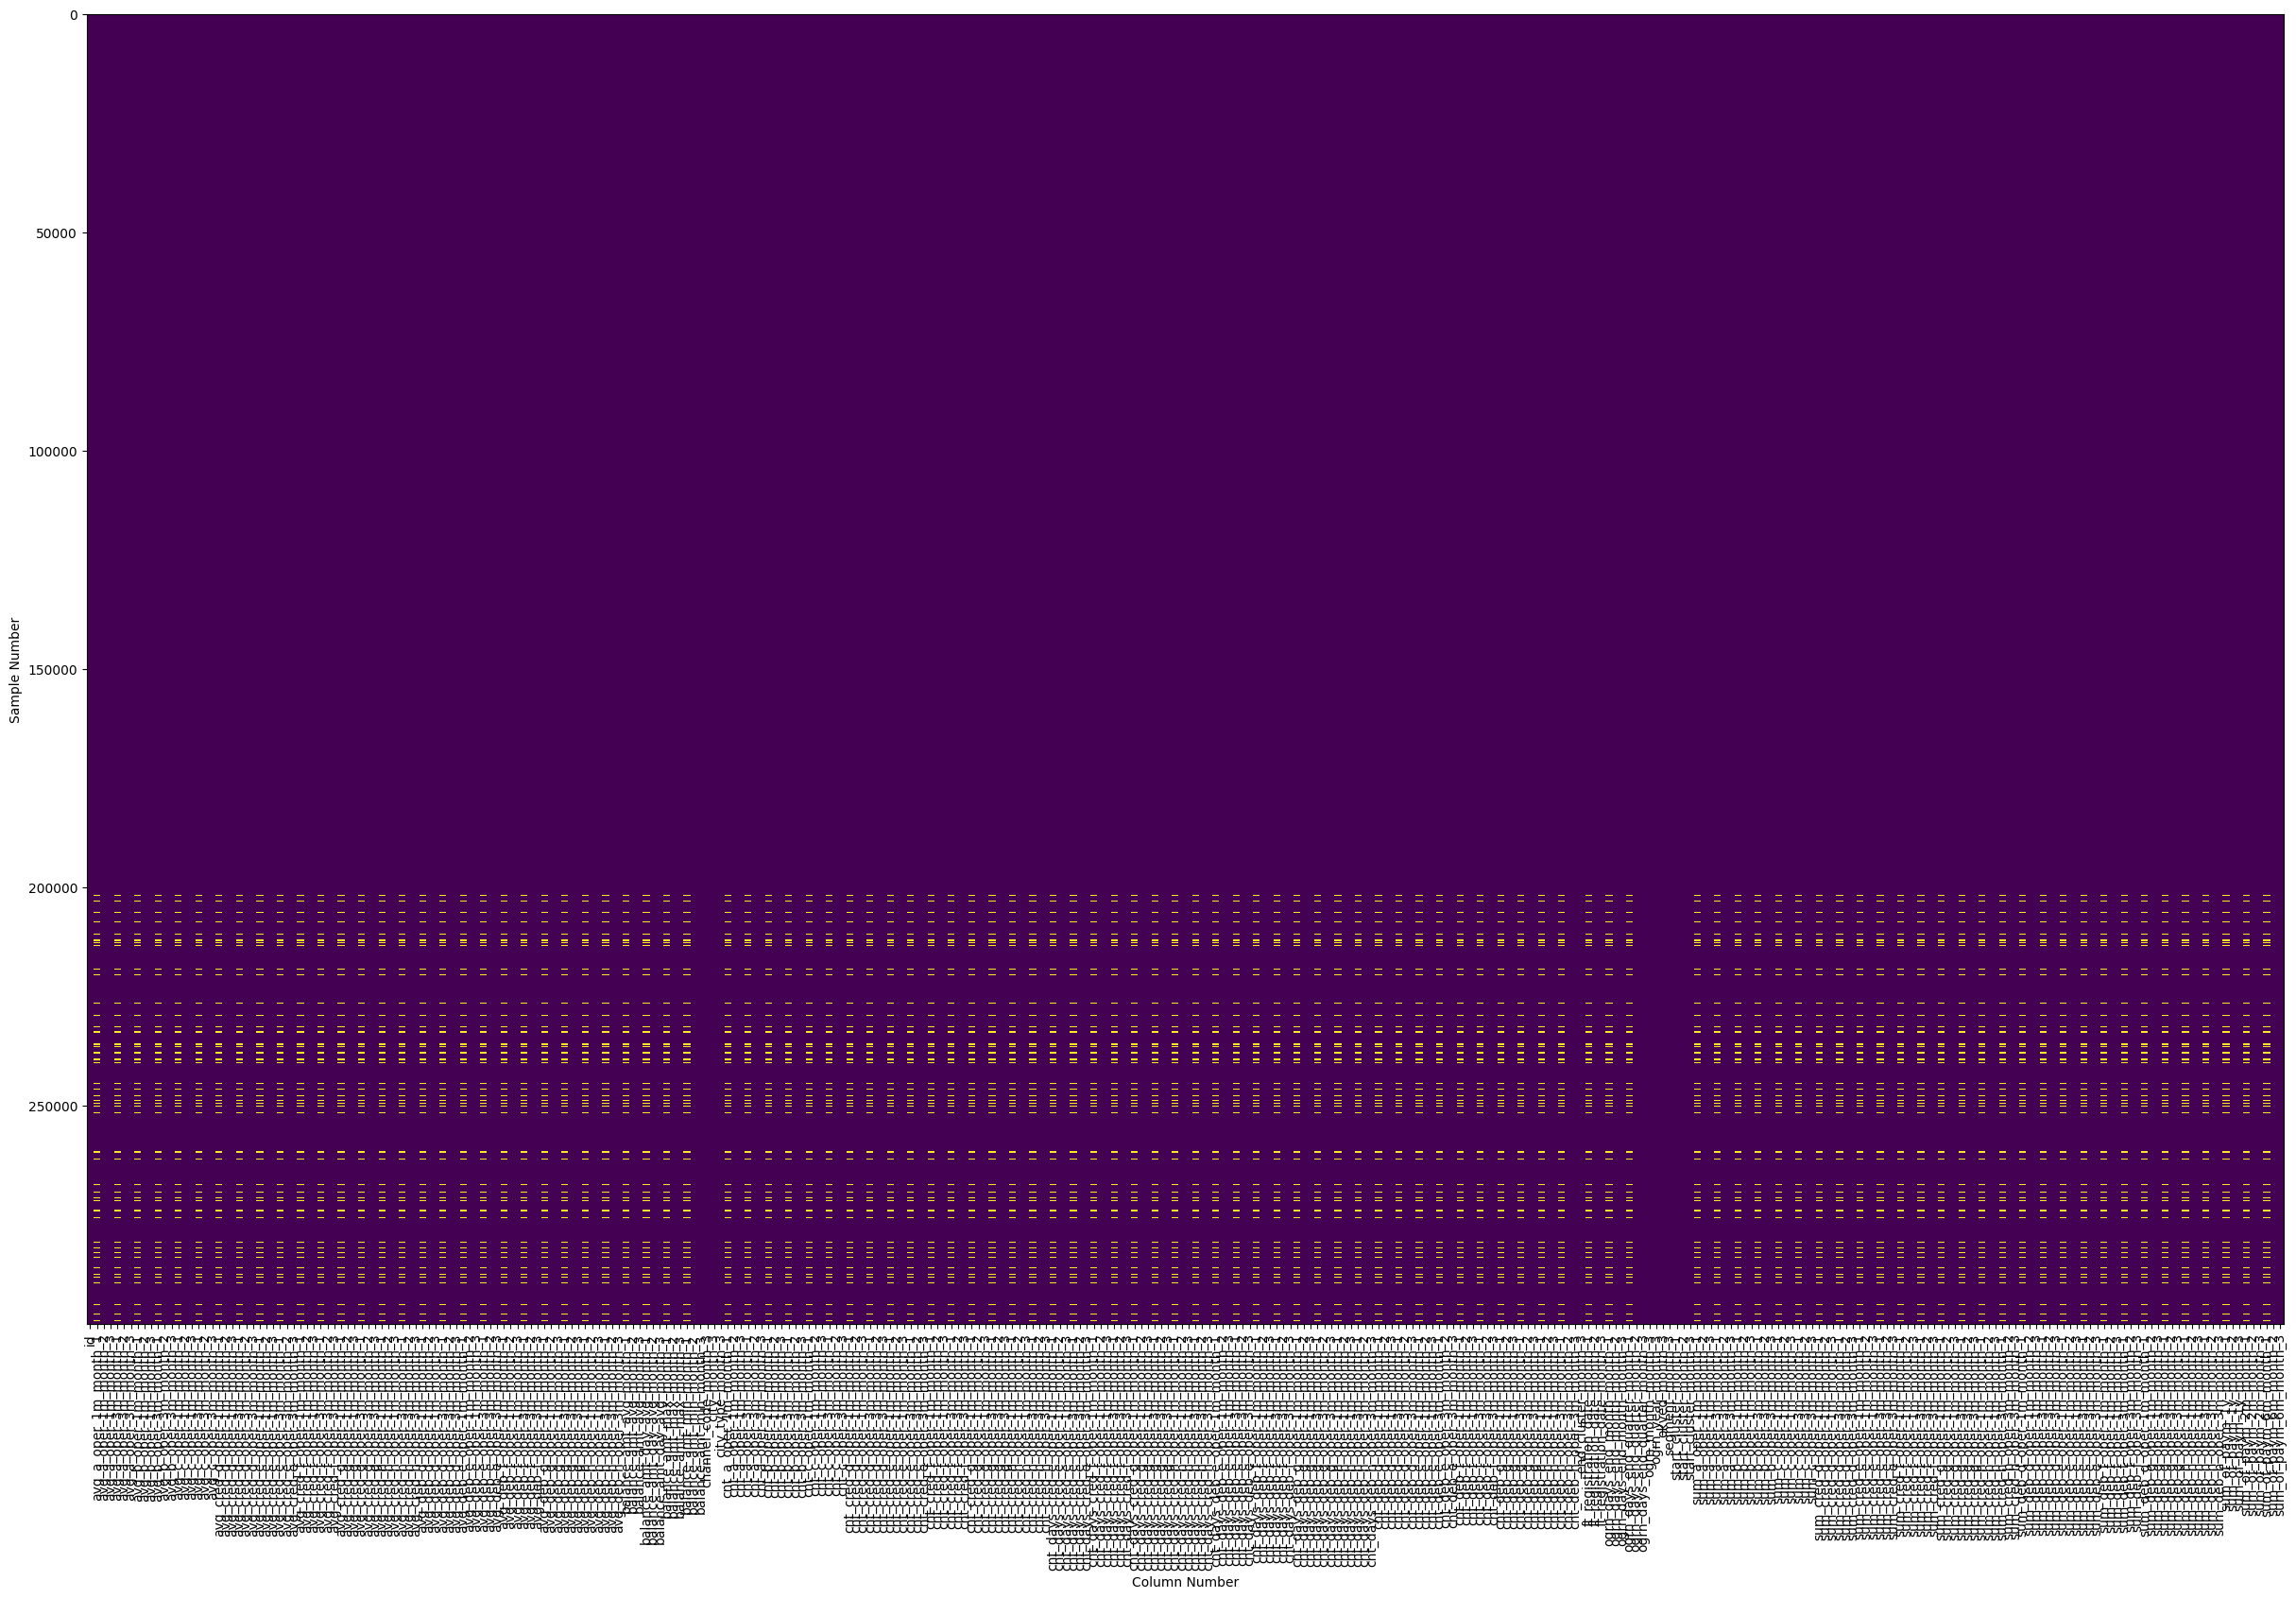

In [ ]:
plt_null_df(pivot_df.isna())

In [ ]:
numeric_cols = pivot_df.select_dtypes(include=['number']).columns[1:]

for i in range(0,len(numeric_cols) - 2,3):
    col1 = numeric_cols[i]
    col2 = numeric_cols[i + 1]
    col3 = numeric_cols[i + 2]

    col_name = "-".join(col1.split("_")[:-2])

    pivot_df[f'{col_name}_diff_2_1'] = pivot_df[col2] - pivot_df[col1]

    pivot_df[f'{col_name}_diff_3_2'] = pivot_df[col3] - pivot_df[col2]

    pivot_df[f'{col_name}_mean'] = pivot_df[[col1, col2, col3]].mean(axis=1)



# Сумма колличества операций
cnt_columns = [col for col in df.columns if col.startswith('cnt')]
df['all_cnt'] = df[cnt_columns].sum(axis=1)

# Сумма операций
cnt_columns = [col for col in df.columns if col.startswith('sum')]
df['all_sum'] = df[cnt_columns].sum(axis=1)

In [ ]:
numeric_cols = pivot_df.select_dtypes(include=['number']).columns
for col in numeric_cols:
    min_val = pivot_df[col].min()
    pivot_df[col].fillna(min_val, inplace=True)


In [ ]:
def remove_outliers(df, k=1.5):
    # Создаем копию DataFrame, чтобы избежать изменения исходного DataFrame
    df_cleaned = df.copy()

    # Итерируемся по каждому числовому столбцу
    for column in df_cleaned.select_dtypes(include='number').columns:
        # Вычисляем квартили
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)

        # Вычисляем межквартильный размах (IQR)
        IQR = Q3 - Q1

        # Определяем верхнюю и нижнюю границы для выбросов
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR

        # Заменяем значения за пределами границ на минимальное и максимальное значение
        df_cleaned[column] = df_cleaned[column].clip(
            lower=lower_bound, upper=upper_bound)

    return df_cleaned


# Применяем функцию к DataFrame, чтобы избавиться от выбросов
df = remove_outliers(df)

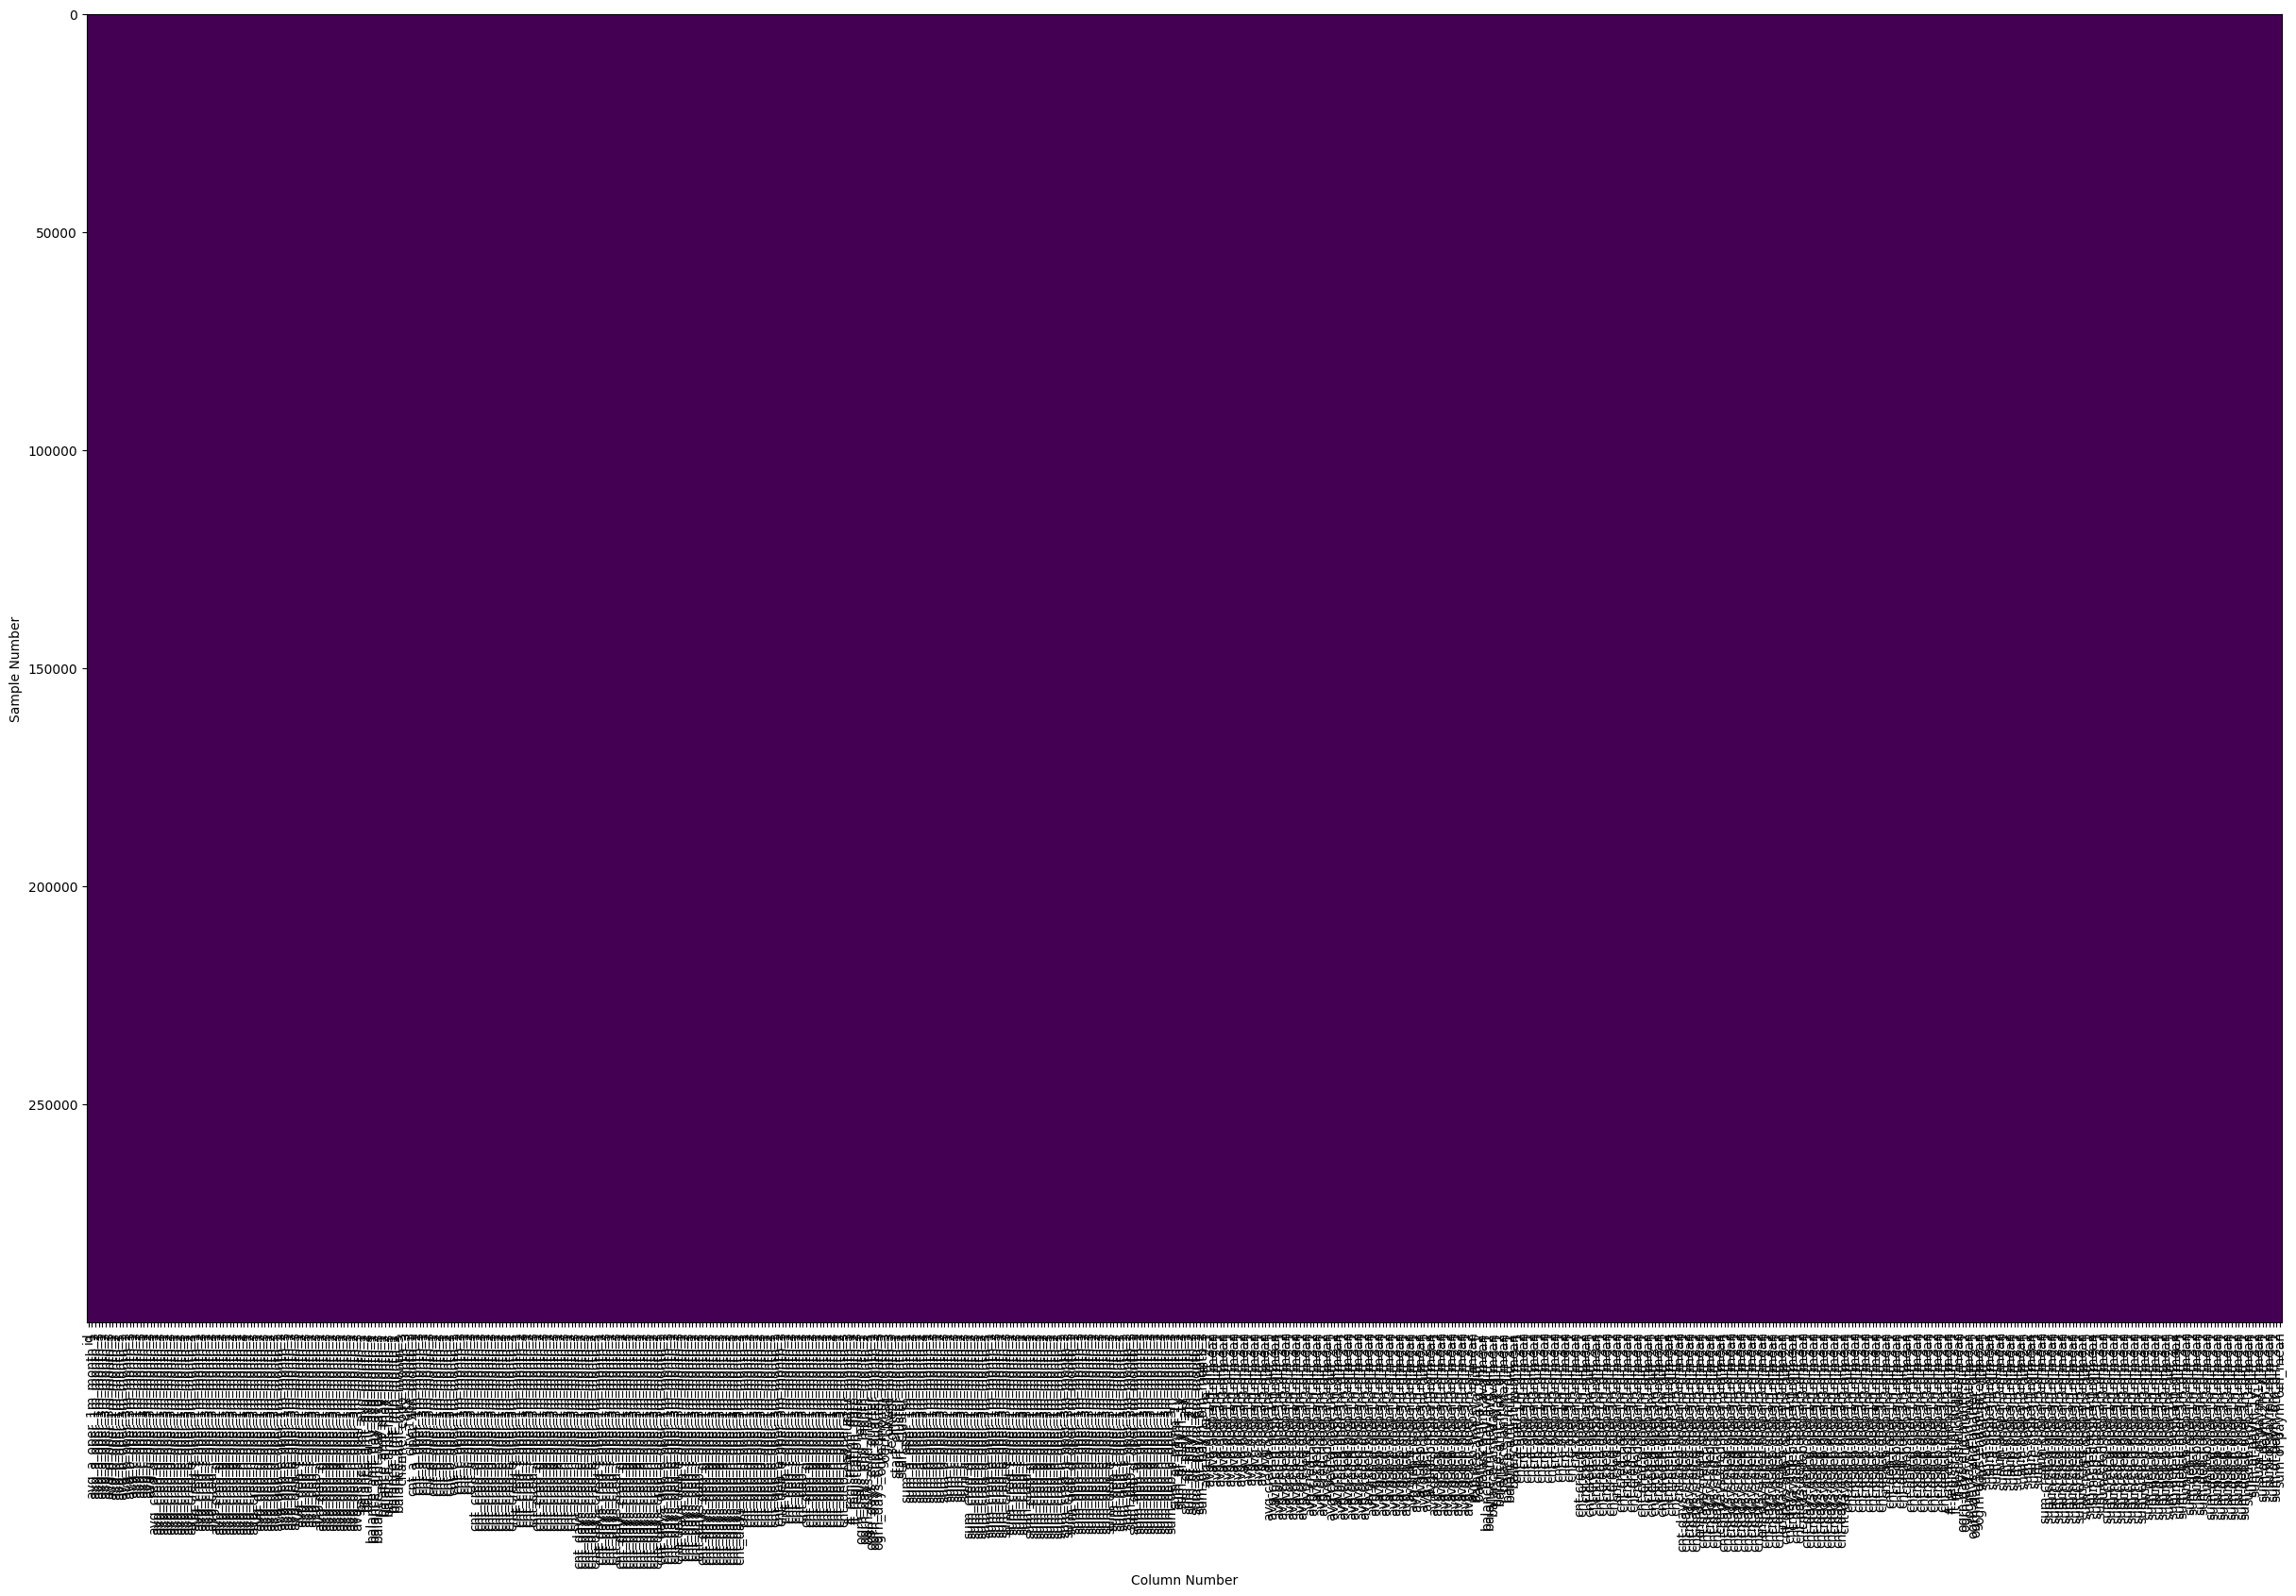

In [ ]:
plt_null_df(pivot_df.isna())

In [ ]:
df = pivot_df

### Воостановление start_claster

In [ ]:
df

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,...,sum-deb-h-oper-3m_mean,sum-of-paym-1y_diff_2_1,sum-of-paym-1y_diff_3_2,sum-of-paym-1y_mean,sum-of-paym-2m_diff_2_1,sum-of-paym-2m_diff_3_2,sum-of-paym-2m_mean,sum-of-paym-6m_diff_2_1,sum-of-paym-6m_diff_3_2,sum-of-paym-6m_mean
0,0,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,0.8532,-0.0251,-0.0059,0.4928,-0.2966,-0.2421,0.6639,0.0004,0.0768,0.5619
1,1,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,0.1599,-0.0185,0.0059,0.0417,-0.0716,-0.0345,-0.0452,-0.0088,-0.0098,0.0347
2,2,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1656,0.0012,0.0024,-0.2903,-0.0121,0.0120,-0.2599,0.0022,0.0043,-0.2843
3,3,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1656,-0.0201,-0.0104,-0.2597,0.0000,0.0000,-0.2740,-0.0256,-0.0000,-0.2859
4,4,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.0783,0.0027,-0.0070,-0.1252,-0.0304,-0.0325,-0.1349,-0.0040,-0.0088,-0.1356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1656,0.0000,0.0000,-0.2961,0.0000,0.0000,-0.2740,0.0000,0.0000,-0.2946
299996,299996,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1617,-0.0004,0.0023,-0.2889,0.0015,0.0121,-0.2685,0.0007,-0.0004,-0.2842
299997,299997,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,0.0735,0.0259,0.0271,-0.1115,0.0291,0.0329,-0.0403,0.0164,0.0137,-0.0835
299998,299998,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1656,-8.4971,0.0000,-0.2961,-40.9736,0.0000,-0.2740,-92.1327,0.0000,-0.2946


In [ ]:
train_data = df[df['start_cluster_month_3'] != 'missing'].drop(
    ['id',  'end_cluster_month_3'], axis=1)
predict_data = df[df['start_cluster_month_3'] == 'missing'].drop(
    ['id', 'end_cluster_month_3'], axis=1)



label_encoders = {}

for col in cat_names:
    label_encoders[col] = LabelEncoder().fit(df[col]) # !!!!!!!!!!!!!!!!!!

    train_data[col] = label_encoders[col].transform(train_data[col])
    predict_data[col] = label_encoders[col].transform(predict_data[col])



X = train_data.drop('start_cluster_month_3', axis=1)
y = train_data['start_cluster_month_3']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# # Определение желаемого количества экземпляров каждого класса
# desired_class_count = 750  # Укажите ваше желаемое количество экземпляров

# # Обработка дисбаланса классов
# balanced_data = pd.DataFrame()
# for cluster in train_data['start_cluster_month_3'].unique():
#     cluster_data = train_data[train_data['start_cluster_month_3'] == cluster]
#     if len(cluster_data) < desired_class_count:
#         resampled_data = resample(
#             cluster_data, replace=True, n_samples=desired_class_count, random_state=42)
#     else:
#         resampled_data = cluster_data.sample(
#             n=desired_class_count, replace=False, random_state=42)
#     balanced_data = pd.concat([balanced_data, resampled_data])
# display(balanced_data['start_cluster_month_3'].value_counts())



# X = balanced_data.drop('start_cluster_month_3', axis=1)
# y = balanced_data['start_cluster_month_3']

# categorical_columns = X.select_dtypes(include=['object']).columns
# X[categorical_columns] = X[categorical_columns].fillna("missing")


#### CATBOOST

In [ ]:
catboost_model_start_cluster = CatBoostClassifier(iterations=1024,
                           depth=6,
                           learning_rate=0.075,
                           random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20
                           )

In [ ]:
def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):

    model.fit(
        x_train, y_train,
        cat_features=np.array(cat_names),
        eval_set=(x_val, y_val),
        verbose=100  # через сколько итераций выводить стату
    )
    model.save_model('catboost_model_start_cluster.json')  # сохранение модели
    feature_importance = model.get_feature_importance(
        prettified=True)  # датасет с важностью признаков

    return feature_importance

In [ ]:
cat_names = X.select_dtypes(include=['object']).columns

feature_importance = train_catboost(
    catboost_model_start_cluster, X_train, y_train, X_val, y_val, cat_names)

0:	learn: 1.9046574	test: 1.8921863	best: 1.8921863 (0)	total: 171ms	remaining: 2m 55s
100:	learn: 0.2462372	test: 0.2282238	best: 0.2282238 (100)	total: 9.49s	remaining: 1m 26s
200:	learn: 0.2284146	test: 0.2165372	best: 0.2165372 (200)	total: 17.8s	remaining: 1m 12s
300:	learn: 0.2229305	test: 0.2136191	best: 0.2136191 (300)	total: 25.6s	remaining: 1m 1s
400:	learn: 0.2189092	test: 0.2118640	best: 0.2118640 (400)	total: 33.3s	remaining: 51.8s
500:	learn: 0.2152533	test: 0.2104368	best: 0.2104275 (499)	total: 41.2s	remaining: 43s
600:	learn: 0.2120252	test: 0.2094955	best: 0.2094902 (598)	total: 49.1s	remaining: 34.6s
700:	learn: 0.2091849	test: 0.2086726	best: 0.2086726 (700)	total: 57s	remaining: 26.3s
800:	learn: 0.2062694	test: 0.2078413	best: 0.2078413 (800)	total: 1m 4s	remaining: 18.1s
900:	learn: 0.2039188	test: 0.2071472	best: 0.2071437 (897)	total: 1m 12s	remaining: 9.95s
1000:	learn: 0.2013223	test: 0.2065626	best: 0.2065602 (999)	total: 1m 20s	remaining: 1.86s
1023:	learn:

### lgb

In [ ]:
params_lgb = {
    'objective': 'multiclass',
    'num_class':17,
    'metric': 'roc-auc',
    'n_estimators': 500,
    'class_weight': 'balanced',
    'random_state': 47}

model_lgb = LGBMClassifier(**params_lgb)

verbose_eval = 50  # Определяет, как часто выводить метрики на валидационном наборе

# Обучаем модель
lgb_model = lgb.LGBMClassifier(**lgb_params, n_estimators=1024, device='gpu', early_stopping_rounds=20, verbose_eval=verbose_eval,  verbose=-1)

lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])



In [ ]:
y_pred = catboost_model_start_cluster.predict(X_val)
print(classification_report(y_val, y_pred))

ValueError: Mix of label input types (string and number)

In [ ]:
X_predict = predict_data.drop('start_cluster_month_3', axis=1)
predicted_clusters = catboost_model_start_cluster.predict(X_predict)

In [ ]:
predicted_clusters_flat = np.ravel(predicted_clusters)
class_counts = pd.Series(predicted_clusters_flat).value_counts()
print(class_counts)

{α}          67884
{α, η}        8428
{}            6586
{other}       5807
{α, γ}        5086
{α, β}        1980
{α, δ}        1350
{α, ε}         872
{α, θ}         760
{α, ψ}         466
{α, μ}         267
{α, ε, η}      200
{α, λ}         148
{α, ε, θ}      113
{α, ε, ψ}       46
{λ}              7
Name: count, dtype: int64


In [ ]:
predicted_index = 0

df_restore_start_cluster = df.copy()
for index, row in df_restore_start_cluster.iterrows():
    # Проверяем, содержится ли в столбце 'date' значение 'month6' и id >= 100000
    if row['id'] >= 200000:
        # Вставляем значение из серии в столбец 'start_cluster_month_3' текущей строки
        df_restore_start_cluster.at[index,
                                    'start_cluster_month_3'] = predicted_clusters[predicted_index][0]
        # Увеличиваем индекс текущей строки в серии
        predicted_index += 1

In [ ]:
matching_rows = df_restore_start_cluster[df_restore_start_cluster['id'] >= 200000].loc[(df_restore_start_cluster['start_cluster_month_1'] == df_restore_start_cluster['start_cluster_month_2']) & (
    df_restore_start_cluster['start_cluster_month_2'] == df_restore_start_cluster['start_cluster_month_3'])]
matching_rows

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,...,sum-deb-h-oper-3m_mean,sum-of-paym-1y_diff_2_1,sum-of-paym-1y_diff_3_2,sum-of-paym-1y_mean,sum-of-paym-2m_diff_2_1,sum-of-paym-2m_diff_3_2,sum-of-paym-2m_mean,sum-of-paym-6m_diff_2_1,sum-of-paym-6m_diff_3_2,sum-of-paym-6m_mean
200000,200000,1.2619,-0.1648,6.2595,4.4611,4.6360,5.4649,-0.0693,-0.0693,-0.0693,...,-0.1524,0.0119,-0.0166,0.6790,0.0164,-0.2092,0.3580,-0.0481,0.0011,0.3007
200001,200001,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1656,0.0000,0.0000,-0.2961,0.0000,0.0000,-0.2740,0.0000,0.0000,-0.2946
200002,200002,9.3303,43.0412,24.7229,16.9913,45.0169,49.5095,-0.0693,-0.0693,-0.0693,...,1.9242,0.6049,0.2411,0.8492,2.5669,0.2716,3.1058,1.0704,0.3487,1.3803
200003,200003,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1656,0.0000,0.0000,-0.2961,0.0000,0.0000,-0.2740,0.0000,0.0000,-0.2946
200005,200005,0.6094,-0.0917,-0.4102,-0.0926,0.0646,0.0782,-0.0693,-0.0693,-0.0693,...,0.0161,-0.2703,0.1033,0.2792,0.0227,0.3307,0.1704,-0.0720,0.0783,0.2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299994,299994,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1656,-0.0049,-0.0003,-0.2689,-0.0069,-0.0049,-0.2624,-0.0167,-0.0030,-0.2747
299995,299995,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1656,0.0000,0.0000,-0.2961,0.0000,0.0000,-0.2740,0.0000,0.0000,-0.2946
299996,299996,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1617,-0.0004,0.0023,-0.2889,0.0015,0.0121,-0.2685,0.0007,-0.0004,-0.2842
299997,299997,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,0.0735,0.0259,0.0271,-0.1115,0.0291,0.0329,-0.0403,0.0164,0.0137,-0.0835


In [ ]:
df.to_parquet("df_after_start_restore.pqt")

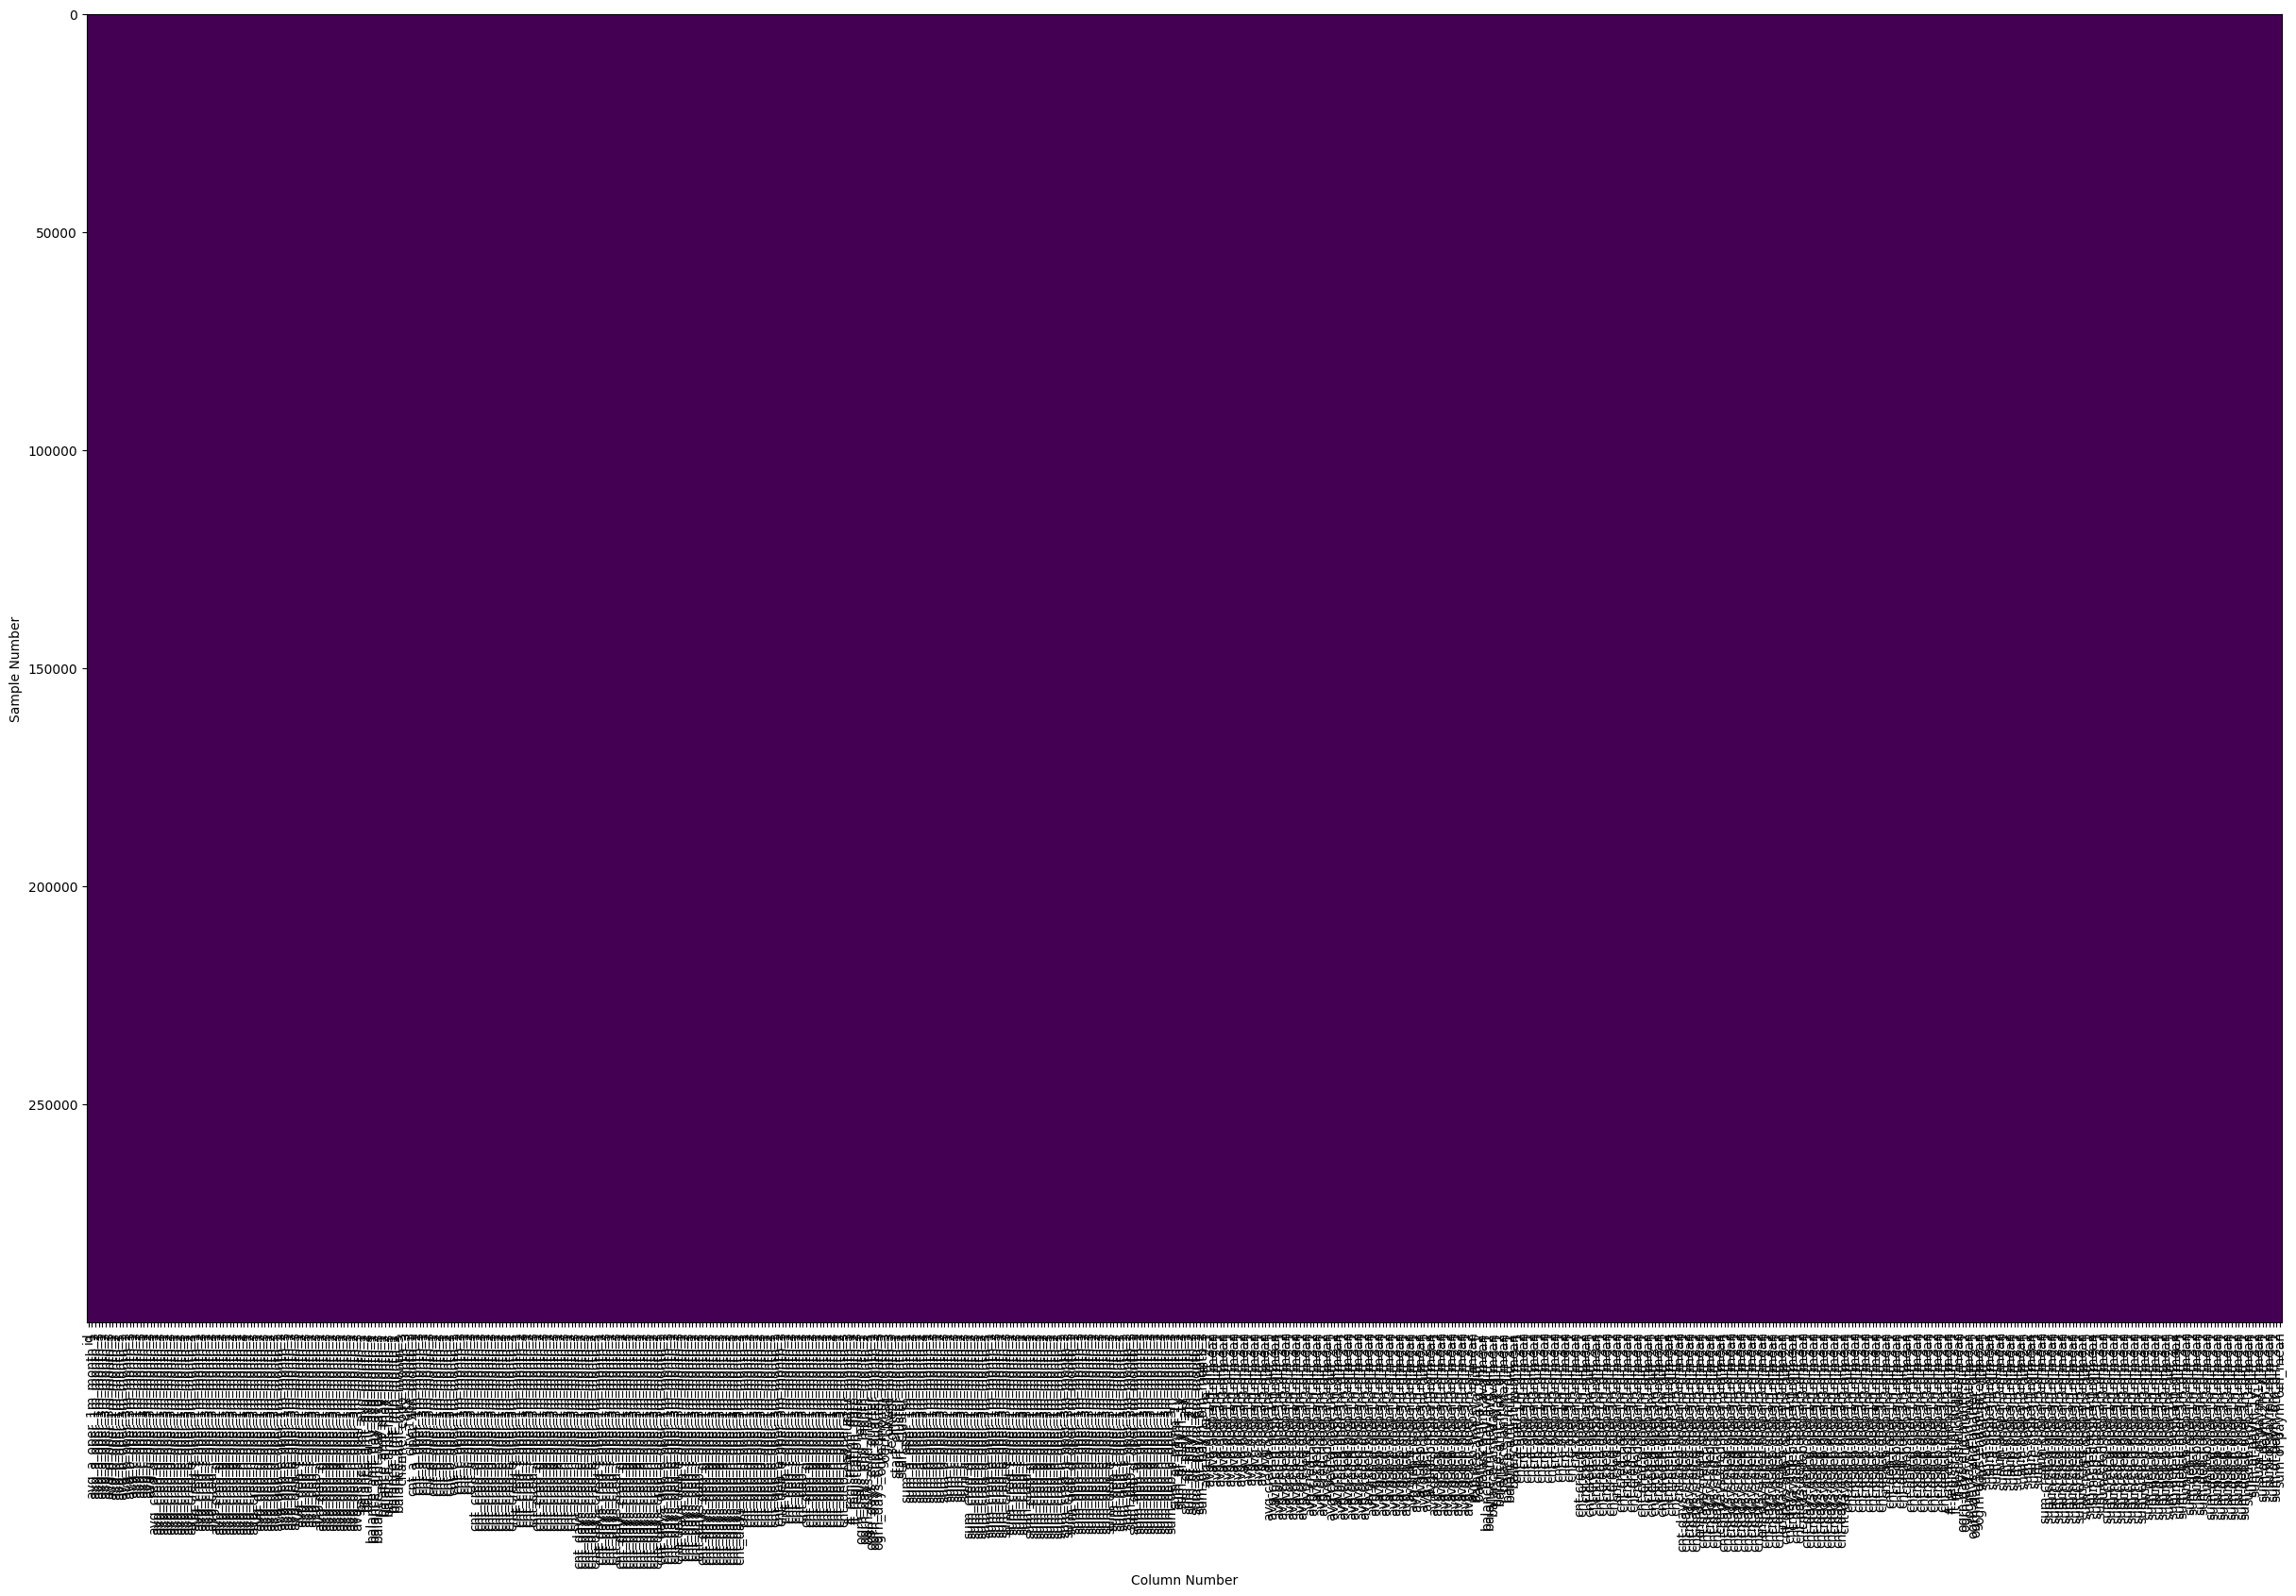

In [ ]:
plt_null_df(df_restore_start_cluster.isna())

## Обучение модели <a class="anchor" id="first-bullet"></a>

In [ ]:
train_df = df_restore_start_cluster[df_restore_start_cluster['id']< 200000]
test_df = df_restore_start_cluster[df_restore_start_cluster['id'] >= 200000]

X = train_df.drop(["id"], axis=1) # оставляю end_cluster чтобы получить пропорцию классов, а потом ниже удалю в коде
y = train_df["end_cluster_month_3"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [ ]:
x_train['end_cluster_month_3'].value_counts()

end_cluster_month_3
{α}          84479
{}           33282
{other}      13280
{α, η}       10016
{α, γ}        9022
{α, β}        2934
{α, θ}        1785
{α, ε}        1476
{α, δ}        1432
{α, ψ}         664
{α, μ}         587
{α, ε, η}      400
{α, ε, θ}      297
{α, λ}         218
{α, ε, ψ}       79
{λ}             45
{α, π}           4
Name: count, dtype: int64

In [ ]:
y_train = x_train['end_cluster_month_3']
x_train = x_train.drop(['end_cluster_month_3'], axis=1)
x_val = x_val.drop(['end_cluster_month_3'], axis=1)

display(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(160000, 634)

(160000,)

(40000, 634)

(40000,)

In [ ]:
catboost_model_end_cluster = CatBoostClassifier(iterations=2000,
                           depth=6,
                           learning_rate=0.075,
                           random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20
                          )


In [ ]:
def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):

    model.fit(
    x_train, y_train,
    cat_features=np.array(cat_names),
    eval_set=(x_val, y_val),
    verbose=15 # через сколько итераций выводить стату
    )
    model.save_model('catboost_model_end_claster.json') # сохранение модели
    feature_importance = model.get_feature_importance(prettified=True) # датасет с важностью признаков

    return feature_importance

In [ ]:
cat_names = x_train.select_dtypes(include=['object']).columns



feature_importance = train_catboost(catboost_model_end_cluster, x_train, y_train, x_val, y_val, cat_names)

0:	learn: 2.2446133	test: 2.2058291	best: 2.2058291 (0)	total: 186ms	remaining: 6m 11s
15:	learn: 1.1151212	test: 1.0334886	best: 1.0334886 (15)	total: 1.76s	remaining: 3m 38s
30:	learn: 0.9423572	test: 0.8605070	best: 0.8605070 (30)	total: 3.49s	remaining: 3m 41s
45:	learn: 0.8877830	test: 0.8080805	best: 0.8080805 (45)	total: 5.11s	remaining: 3m 37s
60:	learn: 0.8661643	test: 0.7893414	best: 0.7893414 (60)	total: 6.69s	remaining: 3m 32s
75:	learn: 0.8539401	test: 0.7796312	best: 0.7796312 (75)	total: 8.22s	remaining: 3m 28s
90:	learn: 0.8450580	test: 0.7733714	best: 0.7733714 (90)	total: 9.75s	remaining: 3m 24s
105:	learn: 0.8375347	test: 0.7679787	best: 0.7679787 (105)	total: 11.4s	remaining: 3m 23s
120:	learn: 0.8326671	test: 0.7651436	best: 0.7651436 (120)	total: 12.9s	remaining: 3m 20s
135:	learn: 0.8279430	test: 0.7622032	best: 0.7622032 (135)	total: 14.4s	remaining: 3m 17s
150:	learn: 0.8245146	test: 0.7602503	best: 0.7602503 (150)	total: 15.9s	remaining: 3m 14s
165:	learn: 0.8

KeyboardInterrupt: 

## Тестирование модели

In [ ]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [ ]:
cluster_weights = pd.read_excel("/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

In [ ]:
y_pred_proba = catboost_model_end_cluster.predict_proba(x_val)
weighted_roc_auc(y_val, y_pred_proba, catboost_model_end_cluster.classes_, weights_dict)

Прогноз на тестовой выборке

In [ ]:
sample_submission_df = pd.read_csv("/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/sample_submission.csv") # поменять на свой
last_m_test_df = test_df
last_m_test_df = last_m_test_df.drop(["id" , 'end_cluster_month_3'], axis=1)

pool2 = Pool(data=last_m_test_df, cat_features=np.array(cat_names))

test_pred_proba = catboost_model_end_cluster.predict_proba(pool2) # last_m_test_df
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=catboost_model_end_cluster.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_4.csv", index=False) # сохранение модели

In [ ]:
sample_submission_df

---
## Выводы и резюме

Мы решали **задачу прогнозирования временного ряда спроса товаров** собственного производства на 14 дней вперёд.

Заказчиком предоставлены исторические данные о **продажах за 1 год**, а также в закодированном виде товарная иерархия и информация о магазинах.  
Прогнозировалось **число проданных товаров в штуках  `pr_sales_in_units`** для каждого **SKU/товара** (2050 шт. в обучающей выборке) в каждом из **10 магазинов**.

Основные **закономерности**, выявленные в результате анализа:
- ***Годовой тренд***  - спад средних продаж в зимний сезон октябрь-март.
- ***Недельная сезонность*** - пик продаж в субботу, спад в понедельник.
- В течение года несколько высоких ***пиков спроса, в основном в районе праздников***. Самые резкие подъёмы продаж в период Нового года и Пасхи. Подъем продаж начинается за несколько дней до.
- 40,6% записей относятся к продажам по промоакциям. Возможны одновременные продажи товара в одном магазине по промо и без.
- В данных представлены продукты с ***неполными временными рядами***: продавались только в дни около Пасхи, начали продаваться полгода назад.
- Во всех магазинах разный ассортимент товаров даже при условии одинаковых характеристик торговой точки.
- Все мета-признаки как характеристики магазинов и товаров показали влияние на средний спрос

На основе имеющихся данных **сгенерированы новые признаки:**  
- Календарные: день недели, число месяца, номер недели, флаг выходного дня (взят из доп. таблицы)
- Лаговые признаки 1-30 дней
- Скользящее среднее за 7 и 14 предыдущих дней
- Кластеризация по характеристикам магазинов и товаров
    
Чтобы временные ряды каждой комбинации Магазин-Товар были полными создан новый датасет, в который добавлены отсутствующие даты с нулевыми продажами.

 Обучение, валидация и выбор лучшего набора гиперпараметров проводится на **кросс-валидации Walk Forward**: подбор гиперпараметров на фолде проводится на valid-выборке, оценка лучшей модели на фолде на test-выборке.   
В итоге выбрана одна модель среди лучших на каждом фолде.

 Предсказание спроса обученной моделью делается последовательно на каждый следующий день с промежуточным перерасчётом лаговых признаков (учитывается предсказанное значение спроса в предыдущий день).

 Для оценки модели использовалась метрика качества  **WAPE**, посчитанная на уровне Магазин-Товар-Дата.  

Лучший результат по качеству и скорости показала модель градиентного бустинга **LightGBM**.  <br>
Полученный результат: WAPE = **0,47**, превышает baseline (предсказание последним известным значением) с метрикой 69%.


